made dist matrix, 0.30623412132263184
made sigma vector, 164.87655353546143
made p_ij_mat, 164.8915150165558
done, 248.91866183280945


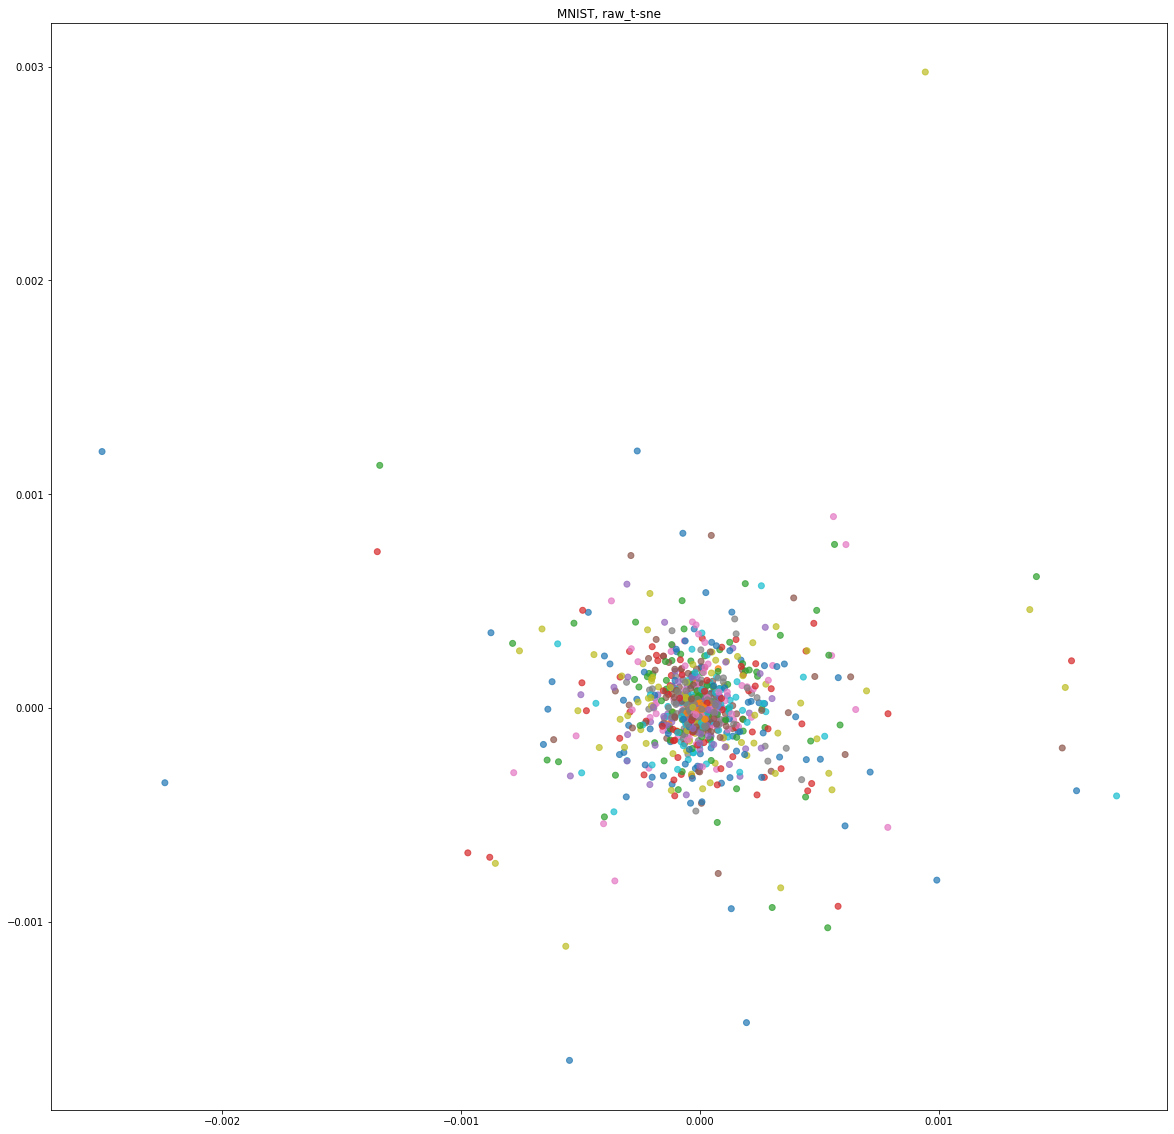

In [2]:
import gzip
import numpy as np
from raw_tsne import raw_TSNE
with gzip.open('train-images-idx3-ubyte.gz', 'rb') as f:
    x_train = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28*28)
with gzip.open('train-labels-idx1-ubyte.gz', 'rb') as f:
    y_train = np.frombuffer(f.read(), np.uint8, offset=8)

X = x_train[0:1000]
label = y_train[0:1000]

tsne_data = raw_TSNE(X, 2, 40, 1000, 200, 0.5, 1013)

import pandas as pd
import matplotlib.pyplot as plt
tsne_data = pd.DataFrame(tsne_data, columns=['z1', 'z2'])
plt.figure(figsize=(20,20))
plt.title('MNIST, raw_t-sne')
plt.scatter(tsne_data.z1, tsne_data.z2, c=label, alpha=0.7, cmap=plt.cm.tab10)

1.5817663669586182


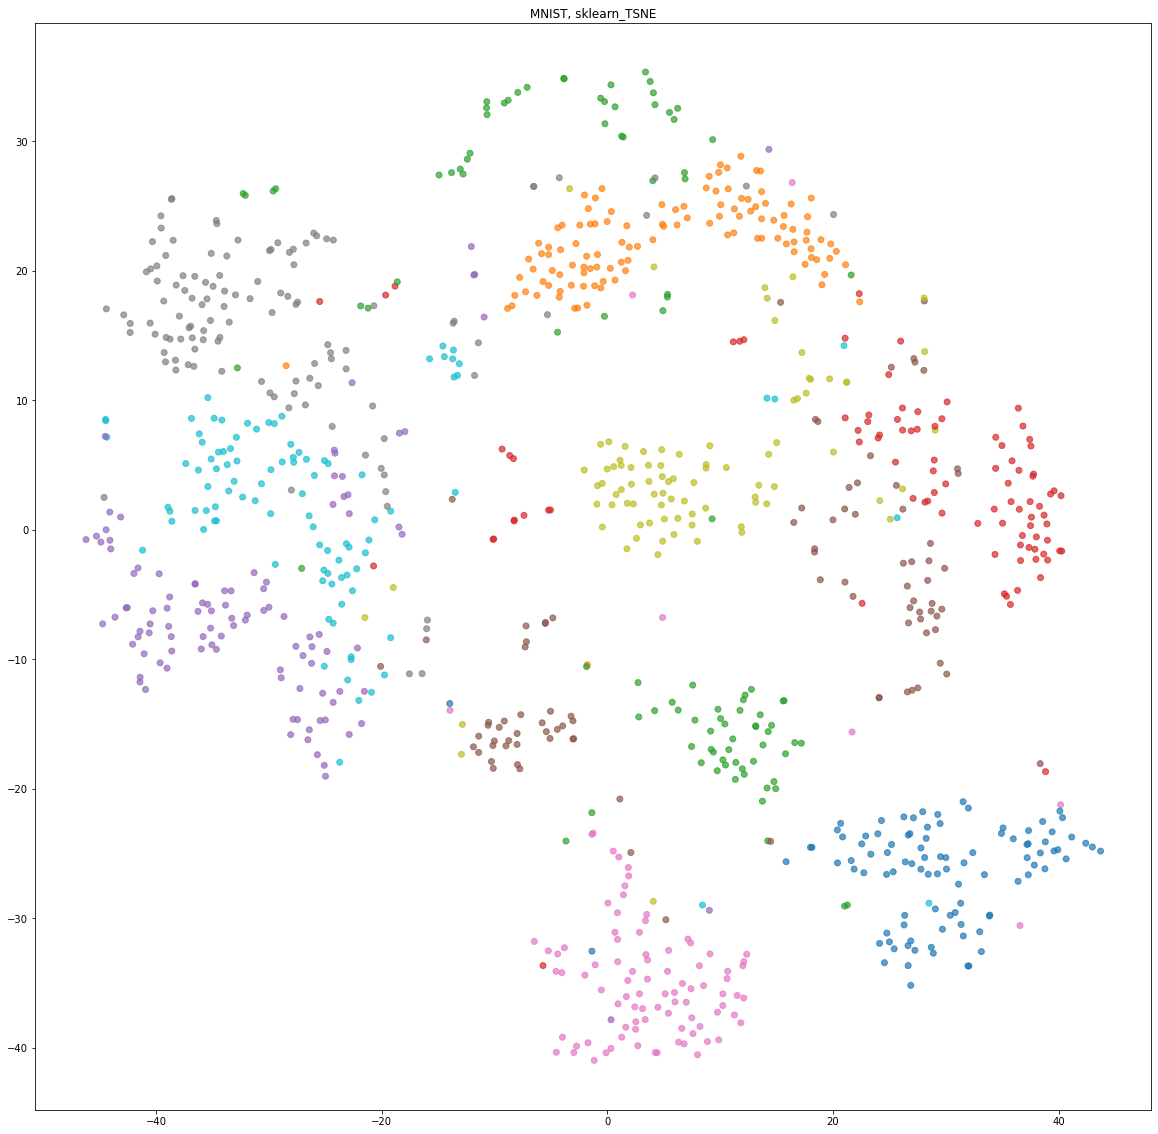

In [4]:
from sklearn.manifold import TSNE
import time
import warnings 
warnings.filterwarnings("ignore") # warning 무시
tsne = TSNE(n_components=2, random_state = 1013)
st = time.time()
tsne_data = tsne.fit_transform(X)
et = time.time()
tsne_data = pd.DataFrame(tsne_data, columns=['z1', 'z2'])
print(et-st)
plt.figure(figsize=(20,20))
plt.title('MNIST, sklearn_TSNE')
plt.scatter(tsne_data.z1, tsne_data.z2, c=label, alpha=0.7, cmap=plt.cm.tab10)